# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 



---
### Why We're Here 

In this notebook, the focus is in developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.


![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, a series of models to perform different tasks are pieced together; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  

### The Road Ahead

The notebook is splitted into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

In [13]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, a demonstration to how to use this detector to find human faces in a sample image is shown.

Number of faces detected: 1


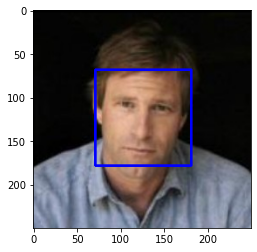

In [14]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [15]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. Our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

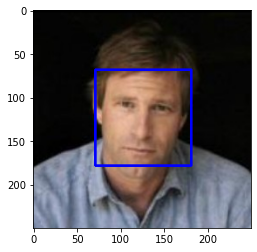

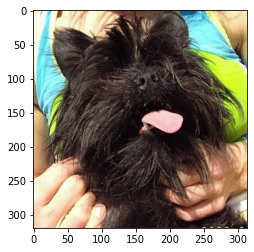

 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.65it/s]

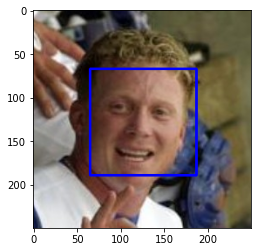

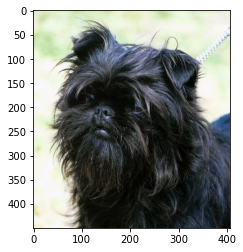

 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.45it/s]

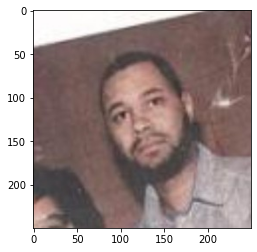

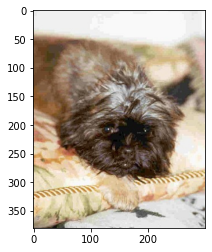

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:01,  1.50it/s]

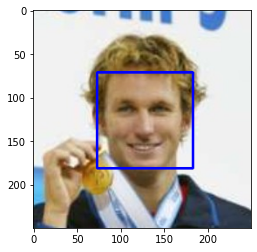

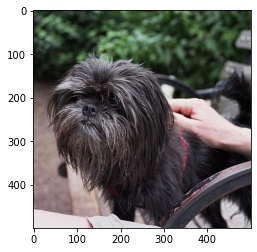

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:02<00:00,  1.46it/s]

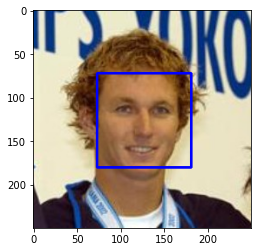

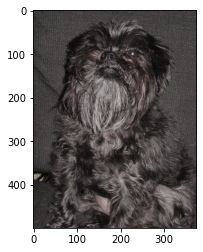

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


In [7]:
from tqdm import tqdm
from PIL import Image, ImageDraw

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detected_human = []
detected_dog = []

for human, dog in tqdm(zip(human_files_short, dog_files_short), total = 100):
    human_result = face_detector(human)
    dog_result = face_detector(dog)
    detected_human.append(human_result)
    detected_dog.append(dog_result)


In [6]:
print('Human Faces In Human Images Detected Percentage ' + str((sum(detected_human) / len(detected_human)) * 100))
print('Human Faces in Dog Images Detected Percentage ' + str((sum(detected_dog) / len(detected_dog)) * 100))

Human Faces In Human Images Detected Percentage 96.0
Human Faces in Dog Images Detected Percentage 18.0


Let's see if a deep learning approach surpass cv2 face cascade performances.
To check out, we've picked MTCNN as a face detector.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[0.9990208]


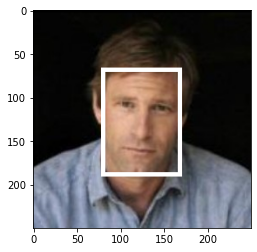

[None]


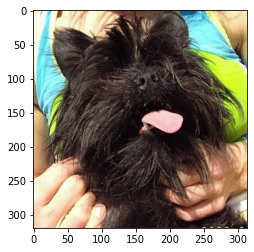

  1%|▊                                                                                 | 1/100 [00:01<01:53,  1.14s/it]

[0.9998331]


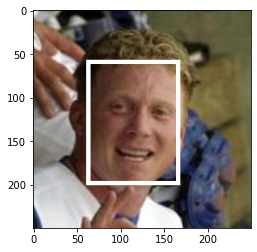

[None]


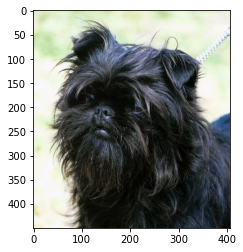

  2%|█▋                                                                                | 2/100 [00:02<01:53,  1.16s/it]

[0.9959629]


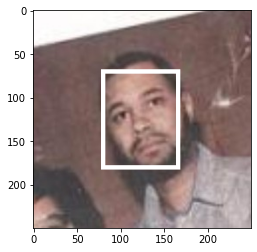

[None]


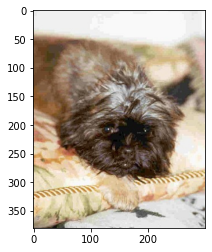

  3%|██▍                                                                               | 3/100 [00:03<01:44,  1.08s/it]

[0.9997242]


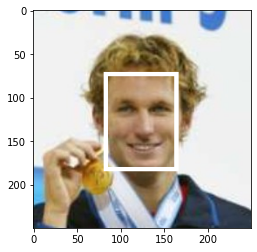

[None]


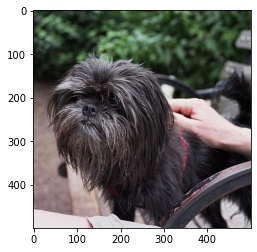

  4%|███▎                                                                              | 4/100 [00:04<01:53,  1.18s/it]

[0.999997]


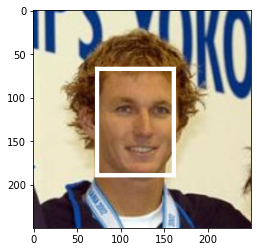

[None]


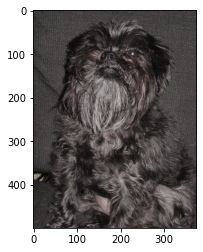

  5%|████                                                                              | 5/100 [00:05<01:51,  1.17s/it]


In [8]:
from facenet_pytorch import MTCNN, extract_face

mtcnn = MTCNN(
    min_face_size=10, keep_all = True, select_largest = False, thresholds = [0.96,0.96,0.96], #[0.6, 0.7, 0.7]
    factor = 0.55
)
def deep_face_detector(img_path, mtcnn):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    print(probs)
    if boxes is not None:
        img_draw = Image.fromarray(img)
        draw = ImageDraw.Draw(img_draw)
        for i, (box, point) in enumerate(zip(boxes, points)):
            draw.rectangle(box.tolist(), width=5)
        return img_draw, len(boxes) > 0
    
    else:
        return img, False


detected_human = []
detected_dog = []

for human, dog in tqdm(zip(human_files_short, dog_files_short), total = 100):
    img,human_result = deep_face_detector(human, mtcnn)
    plt.imshow(img)
    plt.show()
    img,dog_result = deep_face_detector(dog, mtcnn)
    plt.imshow(img)
    plt.show()
    detected_human.append(human_result)
    detected_dog.append(dog_result)


In [9]:
print('Human Faces In Human Images Detected Percentage ' + str((sum(detected_human) / len(detected_human)) * 100))
print('Human Faces in Dog Images Detected Percentage ' + str((sum(detected_dog) / len(detected_dog)) * 100))

Human Faces In Human Images Detected Percentage 100.0
Human Faces in Dog Images Detected Percentage 0.0


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [19]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we write a function that accepts a path to an image as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision
from torchvision import datasets, models, transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path)
    img = transforms.Resize(size = (256, 256)).forward(img)
    img = transforms.CenterCrop(224).forward(img)
    to_tensor = transforms.ToTensor()
    img = to_tensor(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]).forward(img)
    VGG16.eval()
    
    output = VGG16(img.view(1, img.shape[0], img.shape[1], img.shape[2]))
    _, pred = torch.max(output, 1)
            
    return pred # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    return (151 <= VGG16_predict(img_path) <= 268)
    

### Assess the Dog Detector

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

vgg_human_result = []
vgg_dog_result = []
for human, dog in tqdm(zip(human_files_short, dog_files_short), total = 100):
    human_result = dog_detector(human)
    dog_result = dog_detector(dog)
    vgg_human_result.append(human_result)
    vgg_dog_result.append(dog_result)
print('Dogs In Human Images Detected Percentage ' + str((sum(vgg_human_result) / len(vgg_human_result)) * 100))
print('Dogs in Dog Images Detected Percentage ' + str((sum(vgg_dog_result) / len(vgg_dog_result)) * 100))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]

Dogs In Human Images Detected Percentage 0.0
Dogs in Dog Images Detected Percentage 94.0


Let's see if we can find a even better performing pre-trained model.

In [10]:
DENSENET = models.densenet161(pretrained=True)

In [11]:
def DENSENET_predict(img_path):
   
    img = Image.open(img_path)
    img = transforms.Resize(size = (256, 256)).forward(img)
    img = transforms.CenterCrop(224).forward(img)
    to_tensor = transforms.ToTensor()
    img = to_tensor(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]).forward(img)
    DENSENET.eval()
    
    output = DENSENET(img.view(1, img.shape[0], img.shape[1], img.shape[2]))
    _, pred = torch.max(output, 1)
            
    return pred # predicted class index

In [12]:
def dog_detector_densenet(img_path):
    return (151 <= DENSENET_predict(img_path) <= 268)


In [13]:
densenet_human_result = []
densenet_dog_result = []
for human, dog in tqdm(zip(human_files_short, dog_files_short), total = 100):
    human_result = dog_detector_densenet(human)
    dog_result = dog_detector_densenet(dog)
    densenet_human_result.append(human_result)
    densenet_dog_result.append(dog_result)
print('Dogs In Human Images Detected Percentage ' + str((sum(densenet_human_result) / len(densenet_human_result)) * 100))
print('Dogs in Dog Images Detected Percentage ' + str((sum(densenet_dog_result) / len(densenet_dog_result)) * 100))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]

Dogs In Human Images Detected Percentage 0.0
Dogs in Dog Images Detected Percentage 97.0


In [14]:
failed_dogs = []
for idx,l in enumerate(densenet_dog_result):
    if l == False:
        failed_dogs.append(idx)

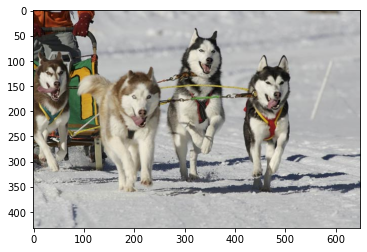

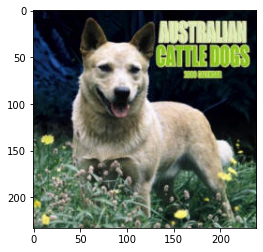

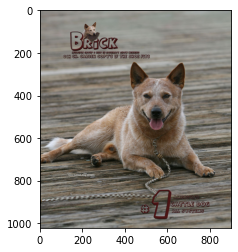

In [15]:
for idx in failed_dogs:
    img = cv2.imread(dog_files_short[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

DenseNet161 works extremely well, but it fails short when text shows.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds. We set a 10% test accuracy as a target for such difficult task.

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, labradors come in yellow, chocolate, and black.  A vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  



### Specify Data Loaders for the Dog Dataset

In [16]:
import os
from torchvision import datasets
from torchvision import datasets, models, transforms
import torch


data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'valid')

breeds = os.listdir('dogImages/train')
breeds = [breed.split('.')[1] for breed in breeds]




data_transform = transforms.Compose([transforms.Resize(size = (224, 224)), transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                       ])

augment_transform = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.Resize(size = (224, 224)),
                                        transforms.ColorJitter(),
                                        transforms.ToTensor()
                                        ])


train_data = datasets.ImageFolder(train_dir,
                                  transform=data_transform)
augment_train = datasets.ImageFolder(train_dir, transform = augment_transform)

val_data = datasets.ImageFolder(val_dir,
                                transform=data_transform)
test_data = datasets.ImageFolder(test_dir,
                                 transform=data_transform)

train_data = torch.utils.data.ConcatDataset([augment_train,train_data])

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))


# define dataloader parameters
batch_size = 100
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Num training images:  13360
Num validation images:  835
Num test images:  836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


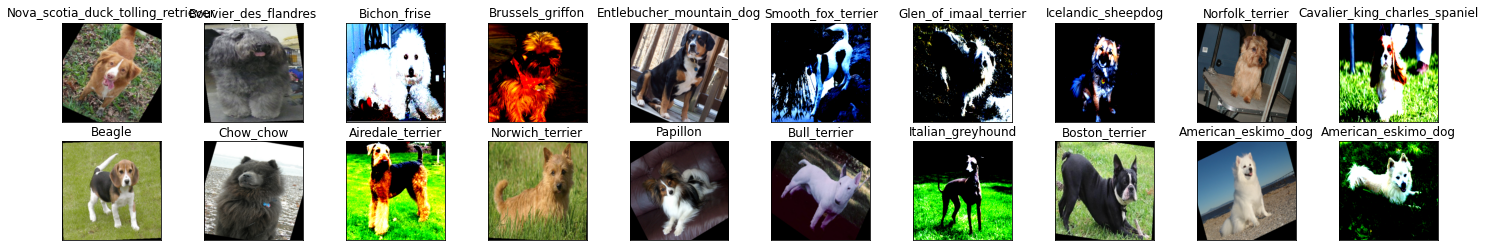

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(breeds[labels[idx]])


We have choosen a 224*224 input size, mainly because several other models have been trained over that input size.
We have been following what's most common in the literature to start.

So, the first step in the transformation pipeline is to resize images to 224*224 size without others transformations, to avoid information losses and noise injection. 
Futhermore, after several training itearations, the model started to overfit while the validation loss was higher than needed to acheive at least 10% accuracy over test set.
So we decided to augment the dataset by duplicating the entire training dataset and applying different transformations.
First, a 30 degrees rotation has been applied, then a 50% chance horizontal flip and a random color jitter.
The rationale was feeding the model with different version of each image, to further improve generalization over shapes and colours.
When training over the augmented dataset, the model achieved a lower validation loss and a 11% accuracy over test set.



### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,padding = 1)
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)
        self.conv4 = nn.Conv2d(64,128,3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 14 * 14, 700)
        self.fc2 = nn.Linear(700, 133)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 14 * 14)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [19]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


We tried to squeeze as many convolutional layer as possible based on the input size provided, trying to detect features more and more significant to classify dog breeds. So, we've added some max pooling layer to highlight relevant features and prevent overfitting as well.
Then, a fully connected layer with 700 hidden nodes has been choosen after several iterations (a bit of a grid search) as well as dropout probability, setted to 0.25.
We was ready to further tune and adjust the model, but the aformentioned architecture has been proved to be enough to get the test target accuracy rate.

### Specify Loss Function and Optimizer

In [21]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters())

### Train and Validate the Model

In [21]:
loaders_scratch = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

In [22]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0.0
        total = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            accuracy = 100. * (correct / total)
            
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy : {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            accuracy
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
            
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [23]:
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Test the Model

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.003955


Test Accuracy: 11% (93/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  We set a target of at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

In [25]:
## Specify data loaders
data_transform_transfer = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])


train_transfer = datasets.ImageFolder(train_dir,
                                  transform=data_transform_transfer)

val_transfer = datasets.ImageFolder(val_dir,
                                transform=data_transform_transfer)

test_transfer = datasets.ImageFolder(test_dir,
                                 transform=data_transform_transfer)




# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader_transfer = torch.utils.data.DataLoader(train_transfer, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader_transfer = torch.utils.data.DataLoader(val_transfer, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader_transfer = torch.utils.data.DataLoader(test_transfer, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [26]:
loaders_transfer = {'train': train_loader_transfer, 'valid': val_loader_transfer, 'test': test_loader_transfer}

### Model Architecture

In [27]:
import torchvision.models as models
import torch.nn as nn


## Specify model architecture 
model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False
n_inputs = model_transfer.classifier.in_features
last_layer = nn.Linear(n_inputs, 133)

model_transfer.classifier = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()



In [28]:
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

After implementing DenseNet161, it was clear that the model yields interesting results in detecting dog. 
We thought it was a good candidate to classify dog breeds either.
We loaded the pretrained model and adapted the classifier output layer to handle different classes than the original. 
This tweak has been proved to be sufficient to achieve a 89% accuracy over test set.


### Specify Loss Function and Optimizer

In [29]:
criterion_transfer = criterion = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.005)

### Train and Validate the Model

In [ ]:
# train the model
n_epochs = 75
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [31]:
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Test the Model

In [32]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.368841


Test Accuracy: 89% (747/836)


### Predict Dog Breed with the Model

In [33]:
### a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index
class_names = [item[4:].replace("_", " ") for item in train_transfer.classes]

def predict_breed_transfer(img_path, model, classes):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img = transforms.Resize(size = (256, 256)).forward(img)
    img = transforms.CenterCrop(224).forward(img)
    to_tensor = transforms.ToTensor()
    img = to_tensor(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]).forward(img)
    model.eval()
    
    output = model(img.view(1, img.shape[0], img.shape[1], img.shape[2]))
    _, pred = torch.max(output, 1)
    return classes[pred]

---
<a id='step5'></a>
## Step 5: Write the Algorithm

Let's write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.



###  Write the Algorithm

In [34]:
mtcnn = MTCNN(
    min_face_size=10, keep_all = True, select_largest = False, thresholds = [0.96,0.96,0.96], 
    factor = 0.55
)
def deep_face_detector_2(img_path, mtcnn):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    if boxes is not None:
        return True
    else:
        return False

In [35]:
def run_app(img_path, model_breed, classes_breed, model_human):
    ## handle cases for a human face, dog, and neither
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    is_dog = dog_detector_densenet(img_path)
    if is_dog:
        breed = predict_breed_transfer(img_path, model_breed, classes_breed)
        print("This is a dog and it's a " + breed)
        plt.imshow(img)
        plt.show()
    else:
        human = deep_face_detector_2(img_path, model_human)
        if human:
            human_breed = predict_breed_transfer(img_path, model_breed, classes_breed)
            print("This is a human that resembles a " + human_breed)
            plt.imshow(img)
            plt.show()
        else:
            print('This is neither a Dog or a Human')
            plt.imshow(img)
            plt.show()
    


---
<a id='step6'></a>
## Step 6: Test the Algorithm


###  Test Your Algorithm on Sample Images!

We'll test the algorithm witht some images we provide. 

This is a human that resembles a Italian greyhound


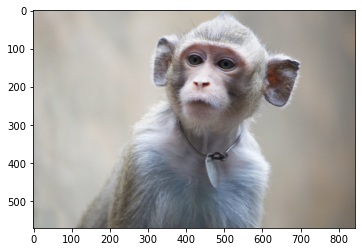

This is a human that resembles a Portuguese water dog


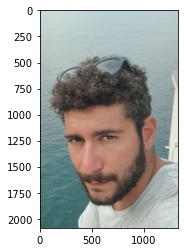

This is neither a Dog or a Human


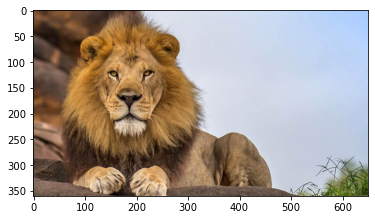

This is neither a Dog or a Human


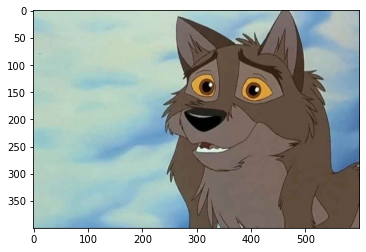

This is a human that resembles a Irish wolfhound


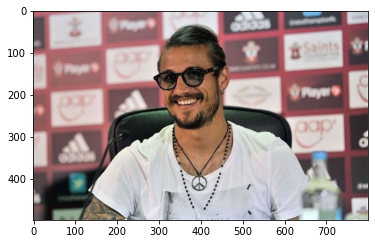

This is a dog and it's a Labrador retriever


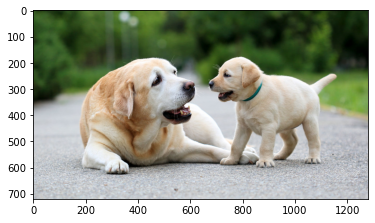

This is a human that resembles a Greyhound


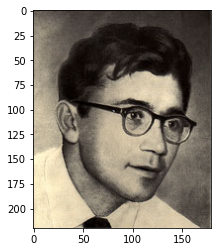

This is a dog and it's a Pomeranian


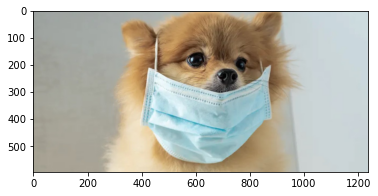

This is neither a Dog or a Human


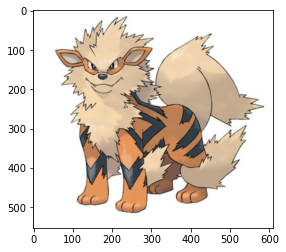

This is neither a Dog or a Human


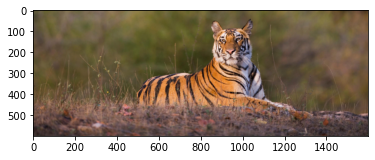

This is a human that resembles a Irish red and white setter


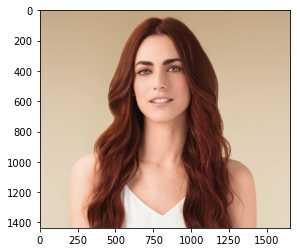

This is neither a Dog or a Human


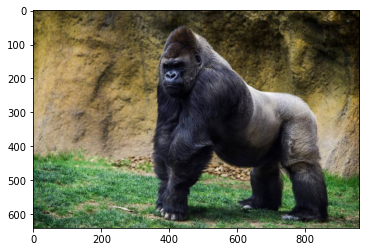

This is neither a Dog or a Human


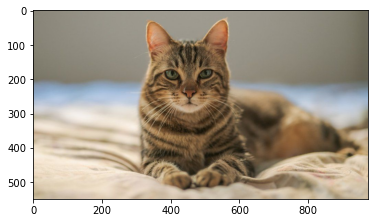

In [36]:
my_files = np.array(glob("my_pictures/*"))
for file in my_files:
    run_app(file, model_transfer, class_names, mtcnn)

__3 Points Of Improvement:__ Generally, the app works well when comes to detect standard dogs or humans pictures.
It correctly detects dogs over other animals, men and women indistinctly. It evens detect myself!
It is obviously not capable of detecting dogs in cartoon dogs pictures. 
If the task is to detect dogs tout court, the model needs either to be trained over this kind of pictures and some tweaks in the feature extractor to better suit the task.
Another weakness is related to the human face detection which could confuse monkeys with humans, since it detects humans alike faces. A possible improvement would be to train a classifier like the dog detector over animals and human, capable of classifying different animals species and not to focus over faces detection.
The app still lacks some precision when classifying dog breeds, especially the ones really similar between them. This is likely due to the fact that the pretrained model used was not intended to solely distinguish between dog breeds. So, more training examples could help to achieve higher accuracy over such dog breeds.


